# Using FFT the right way to find the correct spectrum


In [1]:
import io
from nbformat import read


def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = read(f,3)
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
        
        
    
execute_notebook("create_plot_signal.ipynb")

from numpy import *
from numpy.fft import fft
from matplotlib.pyplot import *
%matplotlib inline

# redefine default figure size and fonts
import matplotlib as mpl
mpl.rc('font', size=16)
mpl.rc('figure',figsize=(12,8))
mpl.rc('lines', linewidth=1, color='lightblue',linestyle=':',marker='o')

## Let's sample 256 points at 30 Hz

In [2]:
fs = 100.0 # sampling frequency (Hz)
T = 3.0 # total actual sample time (s)
y = loadtxt('FFT_Example_data_with_window.txt')

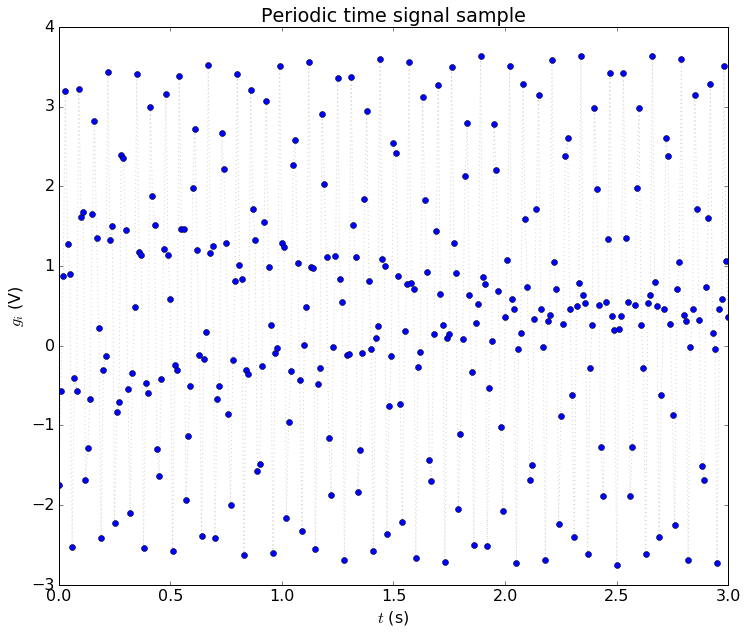

In [3]:
# first, visualize the signal
del_t = 1/fs   # time resolution [s]
t = arange(0.0,T+del_t,del_t)  # time, t (s)

# plotSignal(t,g,fs)
fig = figure(figsize=(12,10))
plot(t,y,marker='o',markerfacecolor='b',linestyle=':',color='lightgrey')
xlabel('$t$ (s)')
ylabel('$g_i$ (V)')
title('Periodic time signal sample')
show()

In [4]:
# does it have a non-zero mean, DC value
DC = y.mean()
print 'DC = %f [V]' % DC

DC = 0.452950 [V]


### Calculate the necessary parameters: $N, \Delta t, \Delta f, f_{fold},N_{freq}$

In [5]:
N = fs*T           # number of data points
del_t = 1./fs      # time resolution (s)
del_f = 1./T        # frequency resolution(Hz)
f_fold = fs/2.     # folding frequency = Nyquist frequency of FFT (Hz)
N_freq = int(N/2.)  # number of useful frequency points

### Frequency analysis using naive FFT

In [6]:
frequency = arange(0,f_fold,del_f)  #frequency (Hz)
Y = fft(y) # FFT 
print Y[:10]
print Y.shape

[ 136.33790000+0.j            0.85689194+0.01756347j
    0.79560330+0.03999151j    0.83065943+0.02317239j
    0.81648114+0.01029308j    0.86012694-0.03048062j
    0.88366205-0.03279026j    0.91944369-0.03388283j
    0.82537342-0.0616697j     0.78619988+0.03823325j]
(301,)


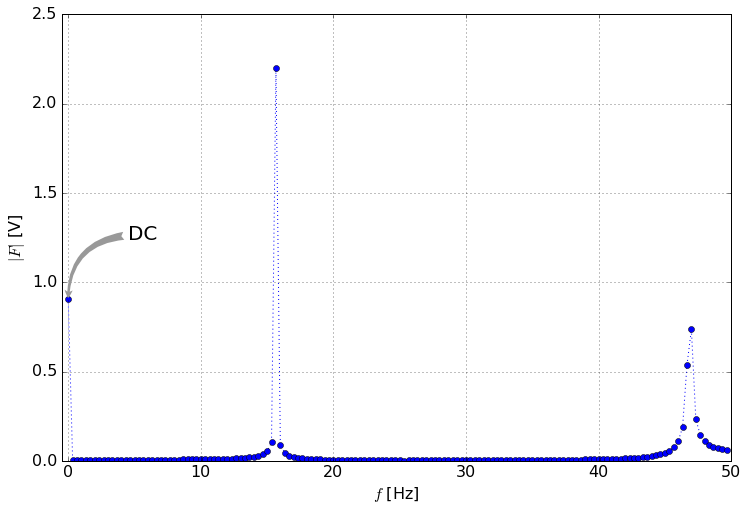

In [7]:
Magnitude = abs(Y)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq])
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')
annotate('DC', xy=(0,.9), xycoords='data',
                xytext=(60, 60), textcoords='offset points',
                size=20,
                arrowprops=dict(arrowstyle="fancy",
                                fc="0.6", ec="none",
                                connectionstyle="angle3,angleA=0,angleB=90"),
                )
show()

### Notes
1. Note the value at 0 Hz, what can we learn from it (we saw it's about 0.45 Volt? 
2. What do we learn from about the frequencies? about 2.1V at 16 Hz and 0.7 Volt at 47 Hz? 
3. Let's remove DC first and see the result

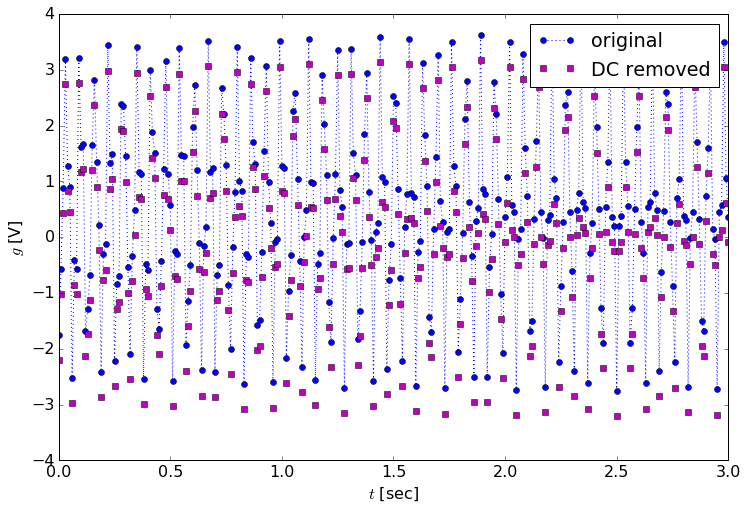

In [8]:
figure()
plot(t,y,t,y-DC,'ms')
xlabel('$t$ [sec]')
ylabel('$g$ [V]')
legend(('original','DC removed'))

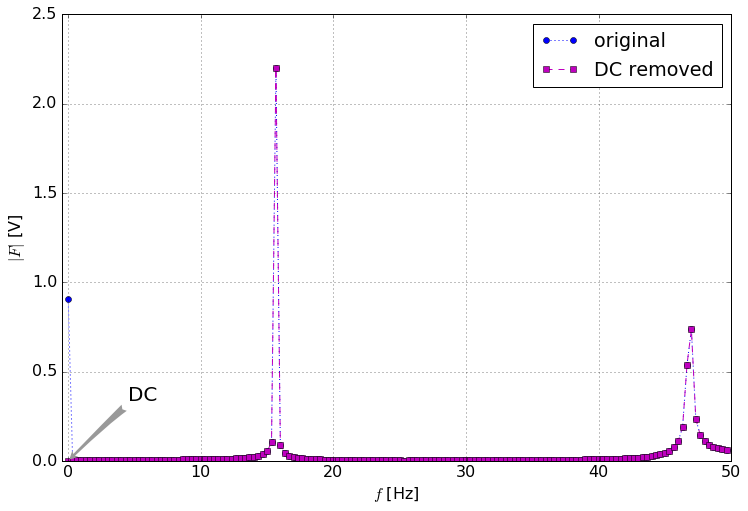

In [9]:
# repeat the frequency analysis
Y = fft(y-DC) # FFT of the signal without DC
Magnitude1 = abs(Y)/(N_freq)  # complex -> amplitude:  |F|/(N/2)

figure()
plot(frequency,Magnitude[:N_freq], frequency,Magnitude1[:N_freq],'--ms')
annotate('DC', xy=(0,0), xycoords='data',
                xytext=(60, 60), textcoords='offset points',
                size=20,
                arrowprops=dict(arrowstyle="fancy",
                                fc="0.6", ec="none",
                                connectionstyle="angle3,angleA=0,angleB=45"),
                )
grid('on')
xlim([-.5,f_fold])
xlabel('$f$ [Hz]')
ylabel('$|F|$ [V]')
legend(('original','DC removed'))
show()

## Use synthetic data generator to play with the FFT options

In [10]:
fs = 15 # sampling frequency, Hz
N = 256 # number of sampling points

t,y = create_signal(fs,N)

Sampling time T =17.067 sec
Number of samples N = 256
Sampling frequency fs = 15.000 Hz


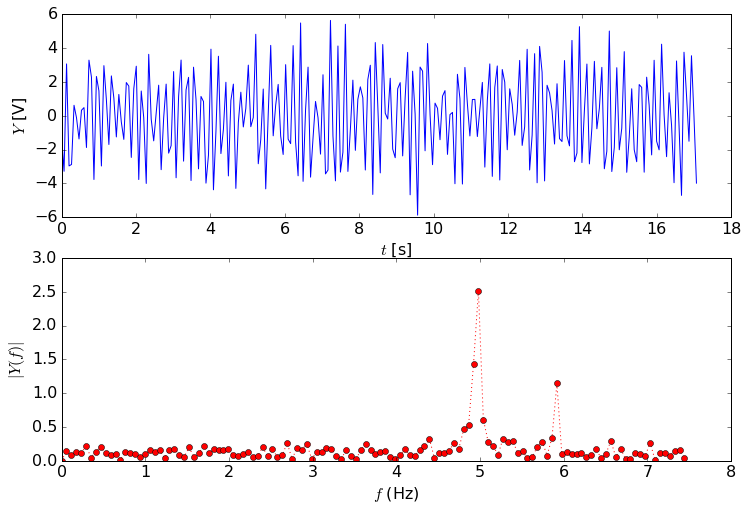

In [11]:
plotSignal(t,y,fs)

# sampling time
T = t[-1] - t[0]
print 'Sampling time T =%6.3f sec' % T
# Number of points
N = len(t)
print 'Number of samples N = %d' % N
# sampling frequency 
fs  = N/T
print 'Sampling frequency fs = %6.3f Hz' % fs

## Sample at higher fs, but not INTERGER times higher

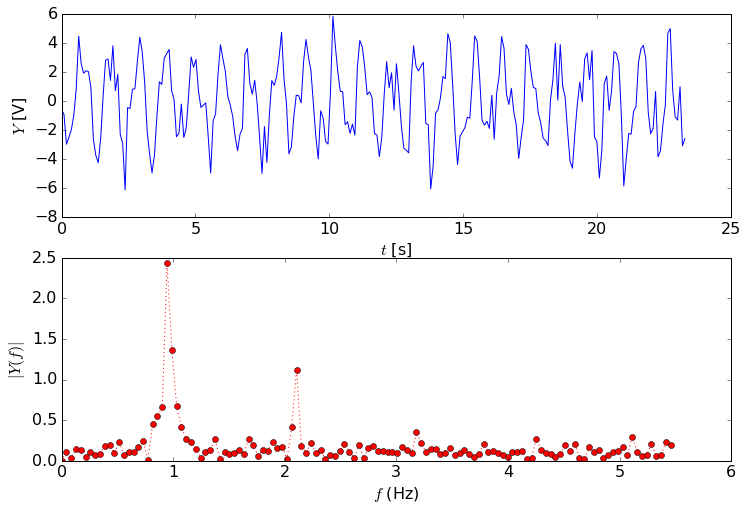

In [12]:
fs = 11 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)

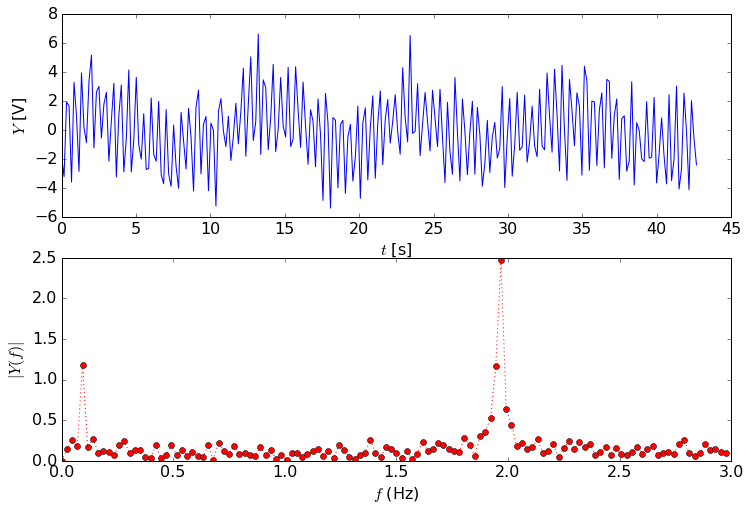

In [13]:
fs = 6 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)

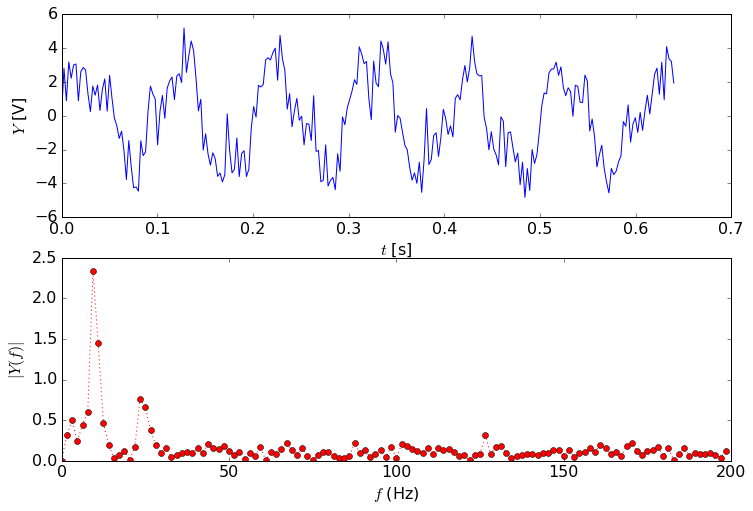

In [14]:
fs = 400 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)

In [15]:
fs = 6; N = 256
t,y = create_signal(fs,N)
frq,Y = spectrum(y,fs)
np.max(np.abs(Y)), frq[np.argmax(np.abs(Y))]

(5.9438945820859779, 0.0)

## There is a problem with the previous sampling 

The 5.7 Hz peak is replaced now by approximately 30 Hz peak. We sampled at 66 Hz, so 30 Hz is below Nyquist and all seems to be fine
But we know that if the right frequency is 30.3 or 30.15 Hz, then when we sampled at 30 Hz we should get: |30.3 - 30] = .3 Hz.
We got 5.7 Hz, so it cannot be that 30.3 is correct, or at least we have some discrepancy here. 
Let's do get even higher sampling frequency: fs = 100 Hz it is not X times 66 

2.56324747637 9.765625


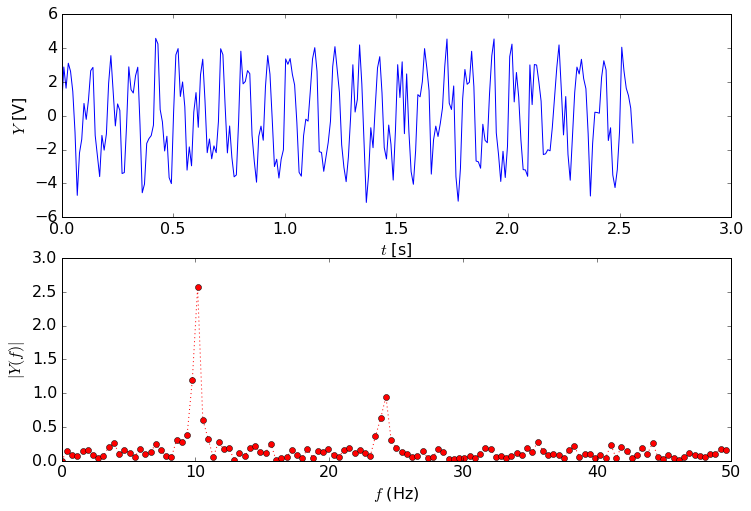

In [16]:
fs = 100; N = 256
t,y = create_signal(fs,N)
frq,Y = spectrum(y,fs)
plotSignal(t,y,fs)
print np.max(np.abs(Y[1:])), frq[np.argmax(np.abs(Y[1:]))]


## So the problem is still there:
the peak is now shifted to 35.5 Hz, let's see: when we sampled at 30 we got aliased 35.5 - 30 = 5.5 Hz. Seems correct,
when we sampled at 66 it was above 2/3*f but below 2*f, so 66 - 35.5 = 30.5 Hz, also seem to fit. So now we have explained (!)
the previous results and we believe that hte signal has 10 Hz and 35.5 Hz (approximately) and 100 Hz is good enough
but we could improve it by going slightly above Nyquist 2*35.5 = 71 Hz, and also try to fix the number of points such that
we get integer number of periods. It's imposible since we have two frequencies, but at least we can try to get it close
enough: 1/10 = 0.1 sec so we could do 256 * 0.1 = 25.6 Hz or X times that = 25.6 * 3 = 102.4 - could be too close
let's try:

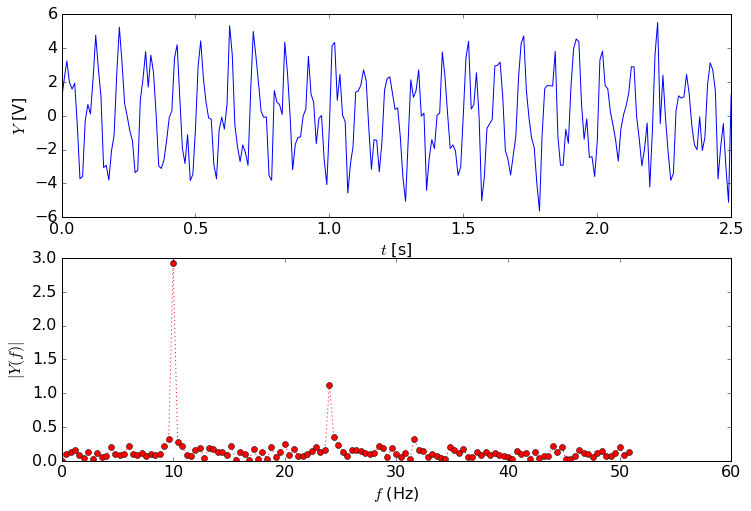

In [17]:
fs = 102.4 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)


Then the same principle to get better 35.5 Hz
1/35.5 * 256 = 7.21 * 15 = 108.16 Hz

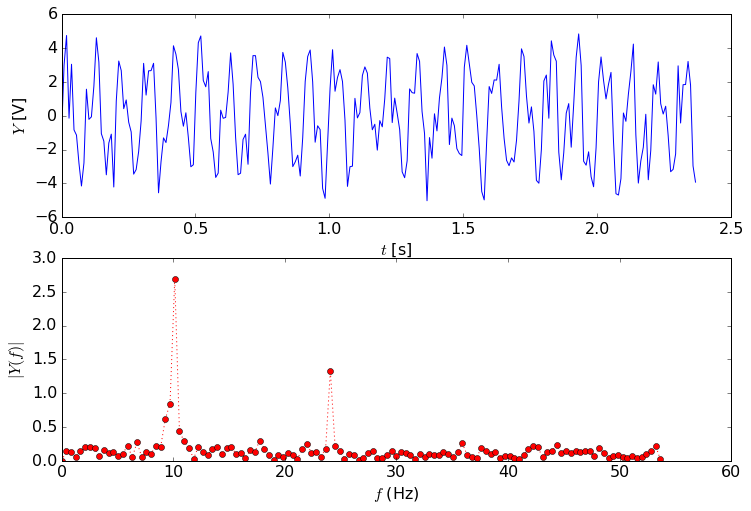

In [18]:
fs = 108.16 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)


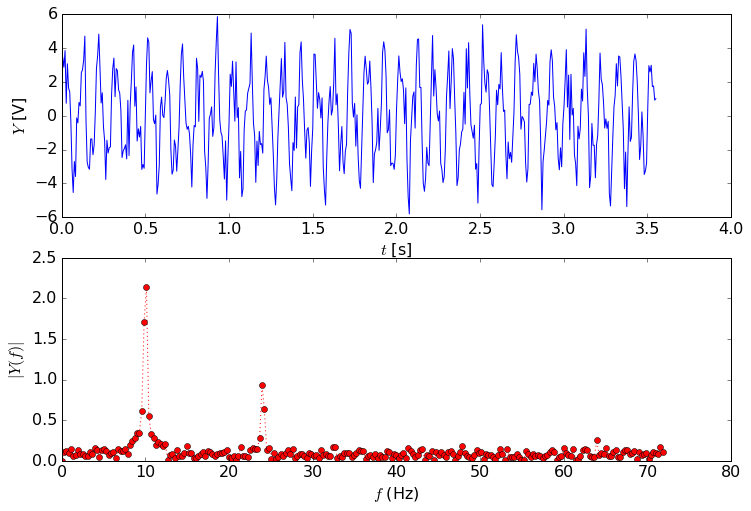

In [19]:
fs = 144.22 # sampling frequency, Hz
N = 512 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)

In [20]:
## Why not to start from high frequencies:

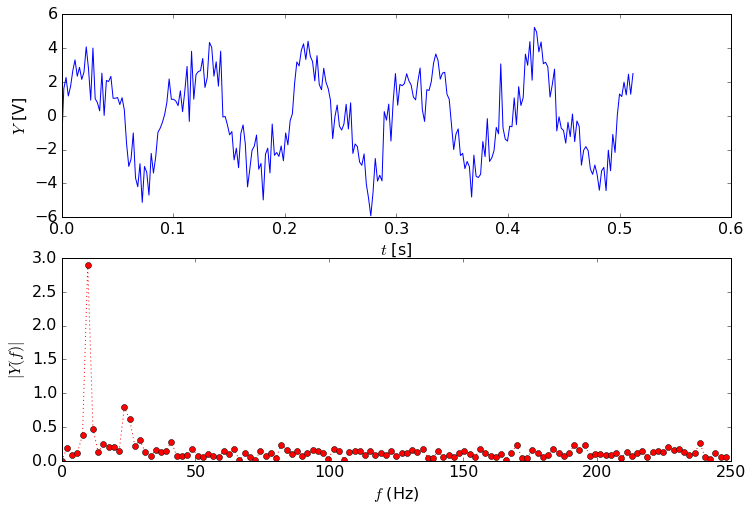

In [21]:
fs = 500 # sampling frequency, Hz
N = 256 # number of sampling points
t,y = create_signal(fs,N)
plotSignal(t,y,fs)
# plotSignal(fs=500,N=256)

* Very poor frequency resolution, $\Delta f = 1/T = fs/N = 500 / 256 = 1.95 Hz$ versus $\Delta f = 100 / 256 = 0.39 Hz$
* peaks are at 9.76 Hz and 35.2 Hz 
* wasting a lot of frequency axis above 2 * 35.7

## Use windowing or low-pass filtering
    

In [22]:
from scipy.signal import hann
h = hann(N)

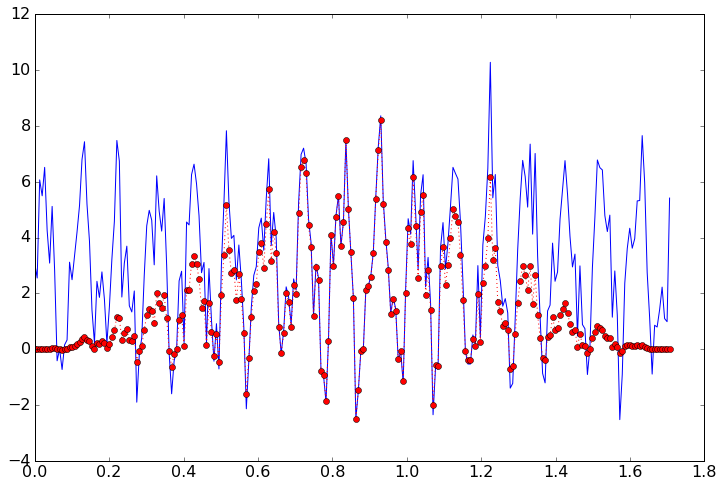

In [23]:
fs = 150; N = 256;
t,y = create_signal(fs,N)
plt.plot(t,y,'b-',t,y*h,'r')

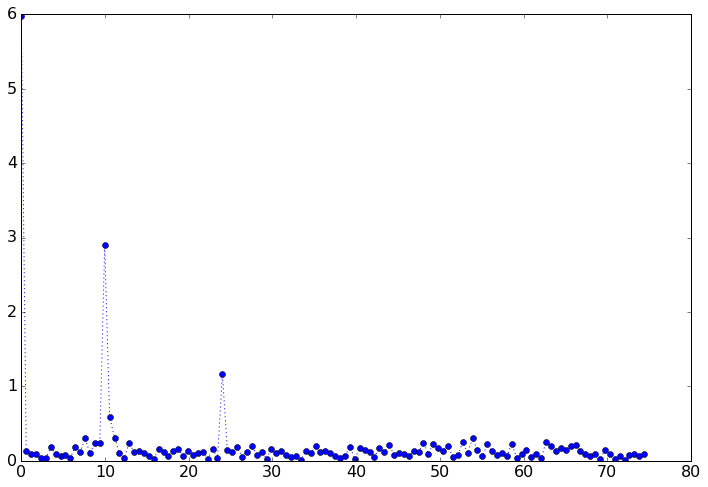

In [24]:
frq,Y = spectrum(y,fs)
plt.plot(frq,abs(Y))

### see Y(0) - it means that we forgot to remove the DC 

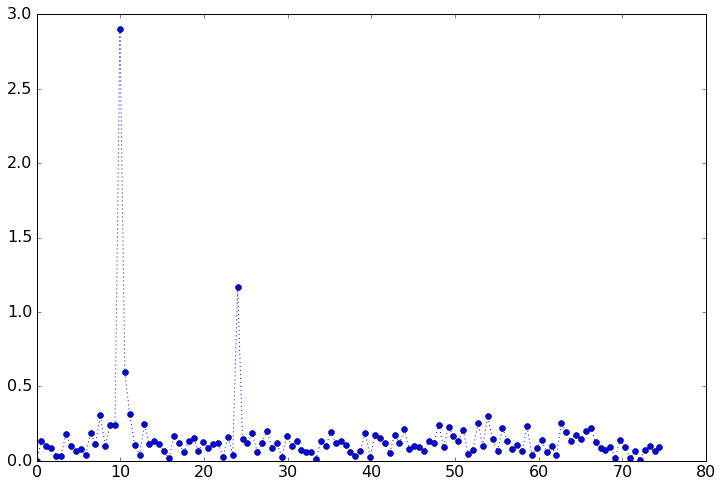

In [25]:
dc = y.mean()
yh = (y-dc)*h
frq,Y = spectrum(y-y.mean(),fs)
plt.plot(frq,np.abs(Y));

### let's try to reconstruct

In [26]:
a = np.abs(Y)

a1,f1 = a.max(),frq[a.argmax()]
print a1,f1
b = a.copy()
b[:a.argmax()+10] = 0 # remove the first peak
a2,f2 = b.max(),frq[b.argmax()]
print a2,f2

2.90128206833 9.9609375
1.16694131959 24.0234375


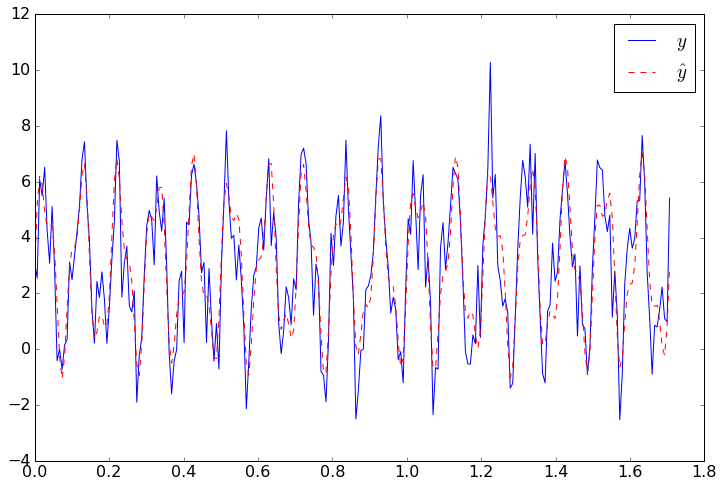

In [27]:
yhat = y.mean() + a1*np.sin(2*np.pi*f1*t) + a2*np.sin(2*np.pi*f2*t)
plt.plot(t,y,'b-',t,yhat,'r--');
plt.legend(('$y$','$\hat{y}$'));